# IMDB dataset

Explore different NN models using the IMDB dataset (from Keras datasets).

Dataset:

- "train_data" and "test_data" are lists of reviews (indices encoding a sequence of words)
- "train_labels" and "test_labels" are lists of 0s and 1s (0 = negative review; 1 = positive review)

# Load libraries and data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow import keras 
from tensorflow.keras import layers
import keras_tuner as kt
import os
import time

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# num_words: integer or "None" (Default = "None" = all words are kept)
# Words are ranked by how often they occur (in the training set) and only the "num_words" 
# most frequent words are kept. Any less frequent word will appear as "oov_char" value in 
# the sequence data.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Retrieves a dict mapping words to their index in the IMDB dataset.
# (word index dictionary: keys are word strings, values are their index)
word_index = imdb.get_word_index()

Word index dictionary

In [2]:
print(f"First element: {list(word_index.items())[0]}")
print(f"First key:     {list(word_index.keys())[0]}")
print(f"First value:   {word_index['fawn']}")

First element: ('fawn', 34701)
First key:     fawn
First value:   34701


# Test GPU

In [3]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"KerasTuner Version: {kt.__version__}")

print('\nDevice name:')
print(tf.test.gpu_device_name())

print('\nList physical devices:')
print(tf.config.list_physical_devices('GPU'))

# Returns whether TensorFlow was built with 
# GPU (CUDA or ROCm) support
print('\nwith GPU (CUDA or ROCm) support?')
print(tf.test.is_built_with_gpu_support())

# Returns whether TensorFlow was built with 
# CUDA (GPU) support
print('\nwith CUDA (GPU) support?')
print(tf.test.is_built_with_cuda())


TensorFlow Version: 2.7.0
KerasTuner Version: 1.1.0

Device name:
/device:GPU:0

List physical devices:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

with GPU (CUDA or ROCm) support?
True

with CUDA (GPU) support?
True


In [4]:
print(f"train_data[0]: {train_data[0]}")
print(f"\ntrain_labels[0]: {train_labels[0]}")
print(f'\nmax word index: {max([max(sequence) for sequence in train_data])}')

train_data[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

train_labels[0]: 1

max word index: 9999


In [5]:
# Default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3

# Decode one of these reviews back to English words
reverse_word_index = dict((index + index_from, word) for (word, index) in word_index.items())
reverse_word_index[start_char] = "[START]"
reverse_word_index[oov_char] = "[OOV]"

# Decode the first sequence in the dataset
decoded_review = " ".join(reverse_word_index[i] for i in train_data[0])
print(decoded_review)

[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [OOV] is an amazing actor and now the same being director [OOV] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [OOV] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [OOV] to the two little boy's that played the [OOV] of norman and paul they were just brilliant children are often left out of the [OOV] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [6]:
# Function to vectorize the data
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

# Vectorize the data
x_train_val = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train_val = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

x_val = x_train_val[:10000]
x_train = x_train_val[10000:]
y_val = y_train_val[:10000]
y_train = y_train_val[10000:]

print(f"Shape x_train: {x_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape x_val: {x_val.shape}")
print(f"Shape y_val: {y_val.shape}")
print(f"Shape x_test: {x_test.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape x_train: (15000, 10000)
Shape y_train: (15000,)
Shape x_val: (10000, 10000)
Shape y_val: (10000,)
Shape x_test: (25000, 10000)
Shape y_test: (25000,)


# Model 1

In [7]:
model_1 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"])

In [8]:
history_1 = model_1.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val, y_val))

Epoch 1/10
30/30 [==============================] - 2s 21ms/step - loss: 0.5598 - accuracy: 0.7533 - val_loss: 0.4109 - val_accuracy: 0.8531
Epoch 2/10
30/30 [==============================] - 0s 11ms/step - loss: 0.3021 - accuracy: 0.9004 - val_loss: 0.2919 - val_accuracy: 0.8874
Epoch 3/10
30/30 [==============================] - 0s 10ms/step - loss: 0.1969 - accuracy: 0.9355 - val_loss: 0.2764 - val_accuracy: 0.8908
Epoch 4/10
30/30 [==============================] - 0s 10ms/step - loss: 0.1434 - accuracy: 0.9557 - val_loss: 0.2895 - val_accuracy: 0.8837
Epoch 5/10
30/30 [==============================] - 0s 10ms/step - loss: 0.1086 - accuracy: 0.9699 - val_loss: 0.3041 - val_accuracy: 0.8832
Epoch 6/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0826 - accuracy: 0.9797 - val_loss: 0.3260 - val_accuracy: 0.8808
Epoch 7/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0643 - accuracy: 0.9861 - val_loss: 0.3537 - val_accuracy: 0.8782
Epoch 8/10
30

In [9]:
history_dict_1 = history_1.history
print(f'history key:\n{history_dict_1.keys()}')

history key:
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Function to plot losses and accuracies

In [10]:
def plot_loss_acc(history_dict):

    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]

    epochs = range(1, len(loss_values) + 1)
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Loss
    axes[0].plot(epochs, loss_values, "bo", label="Training loss")
    axes[0].plot(epochs, val_loss_values, "b", label="Validation loss")
    axes[0].set_title("Training and validation loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    # Accuracy
    axes[1].plot(epochs, acc, "bo", label="Training acc")
    axes[1].plot(epochs, val_acc, "b", label="Validation acc")
    axes[1].set_title("Training and validation accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    #
    plt.show()

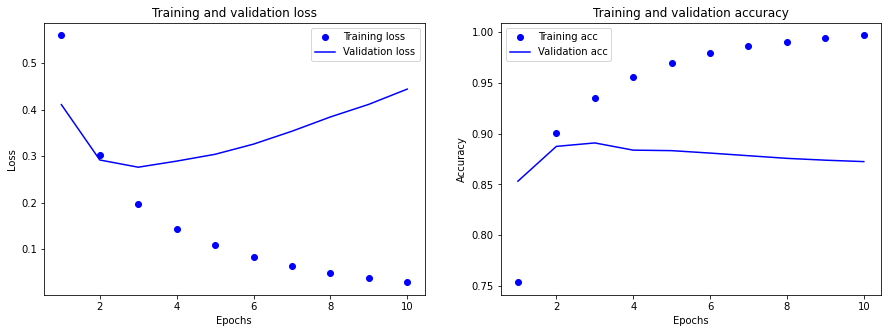

In [11]:
plot_loss_acc(history_dict_1)

## Model 1a

At epoch 3, validation loss has its minimum and validation accuracy peaks. The model starts overfitting after epoch 3, thus we stop the training at epoch 3.

In [12]:
model_1a = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_1a.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"])

In [13]:
history_1a = model_1a.fit(
    x_train,
    y_train,
    epochs=3,
    batch_size=512,
    validation_data=(x_val, y_val))

Epoch 1/3
30/30 [==============================] - 1s 22ms/step - loss: 0.5586 - accuracy: 0.7585 - val_loss: 0.4122 - val_accuracy: 0.8514
Epoch 2/3
30/30 [==============================] - 0s 11ms/step - loss: 0.3086 - accuracy: 0.8966 - val_loss: 0.3007 - val_accuracy: 0.8847
Epoch 3/3
30/30 [==============================] - 0s 9ms/step - loss: 0.2056 - accuracy: 0.9321 - val_loss: 0.2780 - val_accuracy: 0.8897


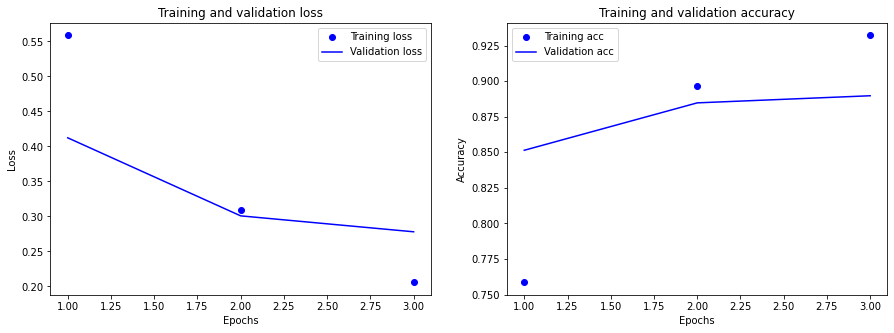

In [14]:
history_dict_1a = history_1a.history

plot_loss_acc(history_dict_1a)

# Model 2

Add:
- more units (Model 2: 20 units; Model 1: 16 units)
- Bacht normalization (normalize before the activation function)
- Dropout

In [15]:
model_2 = keras.Sequential([
    # Layer 1
    layers.Dense(20, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(rate=0.5),
    # Layer 2
    layers.Dense(20, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(rate=0.5),
    # output layer
    layers.Dense(1, activation="sigmoid")
])

model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"])

In [16]:
history_2 = model_2.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size=256,
    validation_data=(x_val, y_val))

Epoch 1/25
59/59 [==============================] - 1s 12ms/step - loss: 0.8131 - accuracy: 0.5310 - val_loss: 0.6800 - val_accuracy: 0.6186
Epoch 2/25
59/59 [==============================] - 0s 8ms/step - loss: 0.7346 - accuracy: 0.5783 - val_loss: 0.6618 - val_accuracy: 0.6986
Epoch 3/25
59/59 [==============================] - 0s 8ms/step - loss: 0.6650 - accuracy: 0.6238 - val_loss: 0.6394 - val_accuracy: 0.7425
Epoch 4/25
59/59 [==============================] - 0s 8ms/step - loss: 0.6216 - accuracy: 0.6534 - val_loss: 0.6104 - val_accuracy: 0.7698
Epoch 5/25
59/59 [==============================] - 0s 8ms/step - loss: 0.5768 - accuracy: 0.6954 - val_loss: 0.5771 - val_accuracy: 0.7904
Epoch 6/25
59/59 [==============================] - 0s 8ms/step - loss: 0.5478 - accuracy: 0.7125 - val_loss: 0.5367 - val_accuracy: 0.8078
Epoch 7/25
59/59 [==============================] - 0s 8ms/step - loss: 0.5213 - accuracy: 0.7343 - val_loss: 0.4972 - val_accuracy: 0.8213
Epoch 8/25
59/59 [=

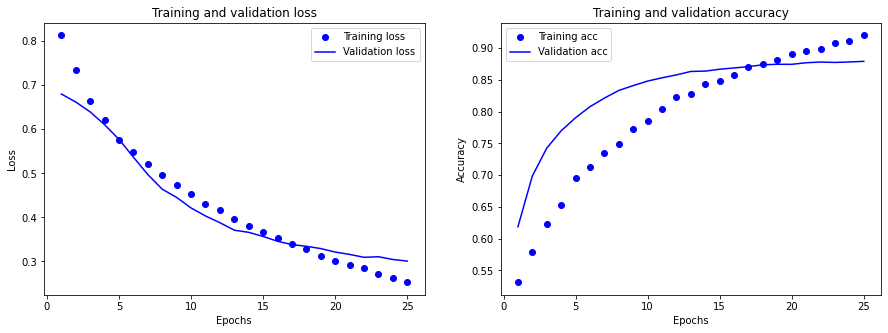

In [17]:
history_dict_2 = history_2.history
plot_loss_acc(history_dict_2)

# Model 3

Add:
- more layers (Model 3: 2 layers; Model 2: 3 layers)
- more units
- More dropout (Model 3: 0.3; Model 2: 0.5)

In [18]:
model_3 = keras.Sequential([
    # Layer 1
    layers.Dense(64, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(rate=0.3),
    # Layer 2
    layers.Dense(32, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(rate=0.3),
    # Layer 3
    layers.Dense(20, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(rate=0.3),
    # output layer
    layers.Dense(1, activation="sigmoid")
])

model_3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"])

In [19]:
history_3 = model_3.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=(x_val, y_val))

Epoch 1/20
59/59 [==============================] - 1s 13ms/step - loss: 0.7511 - accuracy: 0.5381 - val_loss: 0.6778 - val_accuracy: 0.5593
Epoch 2/20
59/59 [==============================] - 0s 8ms/step - loss: 0.6489 - accuracy: 0.6250 - val_loss: 0.6484 - val_accuracy: 0.6472
Epoch 3/20
59/59 [==============================] - 0s 8ms/step - loss: 0.5845 - accuracy: 0.6886 - val_loss: 0.6110 - val_accuracy: 0.7197
Epoch 4/20
59/59 [==============================] - 0s 8ms/step - loss: 0.5325 - accuracy: 0.7393 - val_loss: 0.5623 - val_accuracy: 0.7871
Epoch 5/20
59/59 [==============================] - 0s 8ms/step - loss: 0.4914 - accuracy: 0.7723 - val_loss: 0.5138 - val_accuracy: 0.8200
Epoch 6/20
59/59 [==============================] - 1s 9ms/step - loss: 0.4467 - accuracy: 0.8100 - val_loss: 0.4620 - val_accuracy: 0.8443
Epoch 7/20
59/59 [==============================] - 1s 9ms/step - loss: 0.4134 - accuracy: 0.8357 - val_loss: 0.4206 - val_accuracy: 0.8544
Epoch 8/20
59/59 [=

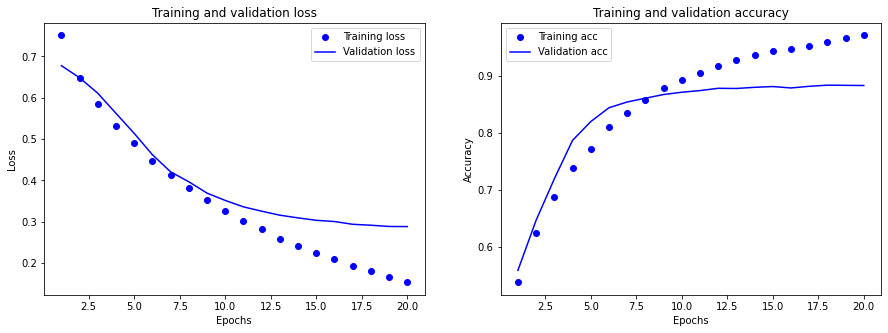

In [20]:
history_dict_3 = history_3.history

plot_loss_acc(history_dict_3)

# Validation set

In [21]:
models = [model_1, model_1a, model_2, model_3]
models_names = ['model_1 ', 'model_1a', 'model_2 ', 'model_3 ']

for n, m in zip(models_names, models):
    r = m.evaluate(x_val, y_val, verbose=0)
    print(f"{n} loss = {r[0]:.3f} --- accuracy = {r[1]:.3f}")

model_1  loss = 0.444 --- accuracy = 0.872
model_1a loss = 0.278 --- accuracy = 0.890
model_2  loss = 0.301 --- accuracy = 0.879
model_3  loss = 0.288 --- accuracy = 0.883


**Model 1a** hat the highest test accuracy

# Hypertuning

In [22]:
def model_builder(hp):

    # Number of hidden layers: 1 - 5 (step: 1)
    hl_min=1
    hl_max=5
    hl_step=1

    # Number of hidden units: 16 - 64 (steps: 16)
    hu_min=16
    hu_max=64
    hu_step=16

    # Dropout rate
    dr_min=0.1
    dr_max=0.5
    dr_step=0.1

    # Learning rate
    lr_min=1e-5
    lr_max=1e-2
    lr_sampling="log"  # log = equal probabilities to each order of magnitude range
    
    
    # Create an instance for a Sequential model 
    model = keras.Sequential()

    # Input layer
    model.add(keras.layers.Flatten())

    # Hidden layers
    # Number of hidden layers: 1 - 5
    # Number of hidden units: 16 - 64 (steps: 16)
    hp_layers = hp.Int("num_layers", min_value=hl_min, max_value=hl_max, step=hl_step)
    for i in range(hp_layers):
        # Add hidden layer
        model.add(keras.layers.Dense(
            units=hp.Int("units_" + str(i), min_value=hu_min, max_value=hu_max, step=hu_step),
            kernel_initializer="he_normal",
            use_bias=False))
        # Batch normalization
        model.add(layers.BatchNormalization()),
        # Activation fulction
        hp_activation = hp.Choice("activation", ["relu", "elu"])
        model.add(layers.Activation(activation=hp_activation)),
        # Dropout
        hp_add_dropout = hp.Boolean("dropout")
        hp_dropout_rate = hp.Float("dropout_" + str(i), min_value=dr_min, max_value=dr_max, step=dr_step)
        if hp_add_dropout:
            model.add(layers.Dropout(rate=hp_dropout_rate))
    
    # Output layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    # Tune the learning rate for the optimizer (choose an optimal value between 0.00001 and 0.01).
    # "log" will assign equal probabilities to each order of magnitude range.
    hp_learning_rate = hp.Float("learning_rate", min_value=lr_min, max_value=lr_max, sampling=lr_sampling)

    #compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=["accuracy"])
    
    return model

In [23]:
model_builder(kt.HyperParameters())

In [24]:
# Instantiate the Hyperband tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',  # 'val_loss'
    max_epochs=20,
    factor=3,
    hyperband_iterations=5,
    seed=42,
    directory='dir_tuner',
    project_name='imdb_tuner',
    # overwrite: Boolean, defaults to False. If False, reloads
    # an existing project of the same name if one is found.
    # Otherwise, overwrites the project.
    # ("overwrite" is a keyword arguments of the "Tuner" class)
    overwrite=False)

# Display search space summary
print(tuner.search_space_summary())


INFO:tensorflow:Reloading Oracle from existing project dir_tuner\imdb_tuner\oracle.json
INFO:tensorflow:Reloading Tuner from dir_tuner\imdb_tuner\tuner0.json
Search space summary
Default search space size: 16
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'cond

In [25]:
# Define root log directory
def get_run_logdir():
    root_logdir = os.path.join(os.curdir, "my_logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


# Create callbacks
run_logdir = get_run_logdir()
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model_hp_tunig", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

The search takes about 1 hour

In [26]:
# Perform hypertuning
tuner.search(
    x_train,
    y_train,
    epochs=20,
    batch_size=32, # 256 # 512
    validation_data=(x_val, y_val),
    callbacks=callbacks)

INFO:tensorflow:Oracle triggered exit


## Retrain the best model

In [27]:
best_hps = tuner.get_best_hyperparameters()[0]

print(best_hps.values)

{'num_layers': 3, 'units_0': 64, 'activation': 'elu', 'dropout': True, 'dropout_0': 0.4, 'learning_rate': 9.191261178883892e-05, 'units_1': 48, 'dropout_1': 0.30000000000000004, 'units_2': 32, 'dropout_2': 0.4, 'units_3': 16, 'dropout_3': 0.30000000000000004, 'units_4': 48, 'dropout_4': 0.30000000000000004, 'units_5': 32, 'dropout_5': 0.2, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '2fbaa06b9fc88fd89ae18000004952c3'}


In [28]:
print(tuner.search_space_summary())

Search space summary
Default search space size: 16
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value'

In [29]:
# Build the model with the optimal hyperparameters and train it
model_hp = tuner.hypermodel.build(best_hps)

In [30]:
# Create callbacks
run_logdir = get_run_logdir()
print('current directiry: ', os.getcwd())
print('Root log directory: ', run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("models_hp", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# Train the model
history_hp = model_hp.fit(
    x_train,
    y_train,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=callbacks)

current directiry:  d:\Projects\ML\imdb_DNN
Root log directory:  .\my_logs\run_2023_03_02-16_30_28
Epoch 1/30
469/469 [==============================] - 5s 8ms/step - loss: 0.6391 - accuracy: 0.6661 - val_loss: 0.3996 - val_accuracy: 0.8417
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.4199 - accuracy: 0.8117 - val_loss: 0.3221 - val_accuracy: 0.8671
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 0.3282 - accuracy: 0.8636 - val_loss: 0.2900 - val_accuracy: 0.8830
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2725 - accuracy: 0.8887 - val_loss: 0.2884 - val_accuracy: 0.8806
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2312 - accuracy: 0.9085 - val_loss: 0.2791 - val_accuracy: 0.8850
Epoch 6/30
469/469 [==============================] - 3s 5ms/step - loss: 0.1969 - accuracy: 0.9243 - val_loss: 0.2870 - val_accuracy: 0.8831
Epoch 7/30
469/469 [=============================

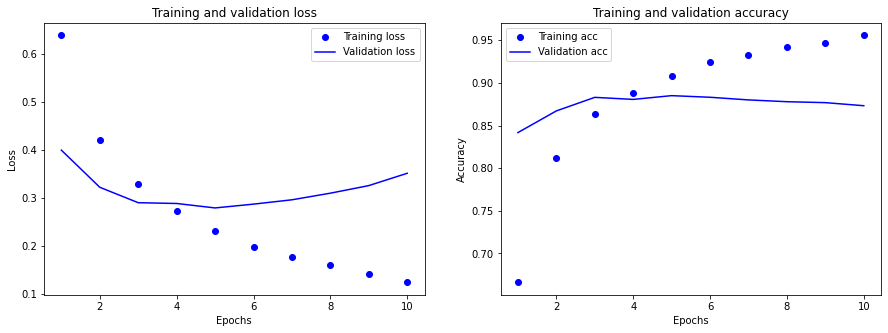

In [31]:
history_dict_hp = history_hp.history

plot_loss_acc(history_dict_hp)

In [32]:
# -----------------------------------------------------------
# To start TensorBoard, write in the terminal:
# $ tensorboard --logdir=./my_logs --port=6006
# -----------------------------------------------------------

In [33]:
model_hp.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_17 (Dense)            (None, 64)                640000    
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64)                0         
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 48)                3072      
                                                      

## Retrain the best model

Only for 5 epochs

Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.6542 - accuracy: 0.6485 - val_loss: 0.4117 - val_accuracy: 0.8308
Epoch 2/5
469/469 [==============================] - 3s 5ms/step - loss: 0.4465 - accuracy: 0.7910 - val_loss: 0.3212 - val_accuracy: 0.8662
Epoch 3/5
469/469 [==============================] - 3s 5ms/step - loss: 0.3448 - accuracy: 0.8545 - val_loss: 0.2911 - val_accuracy: 0.8807
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.2853 - accuracy: 0.8847 - val_loss: 0.2779 - val_accuracy: 0.8857
Epoch 5/5
469/469 [==============================] - 3s 5ms/step - loss: 0.2367 - accuracy: 0.9085 - val_loss: 0.2766 - val_accuracy: 0.8868


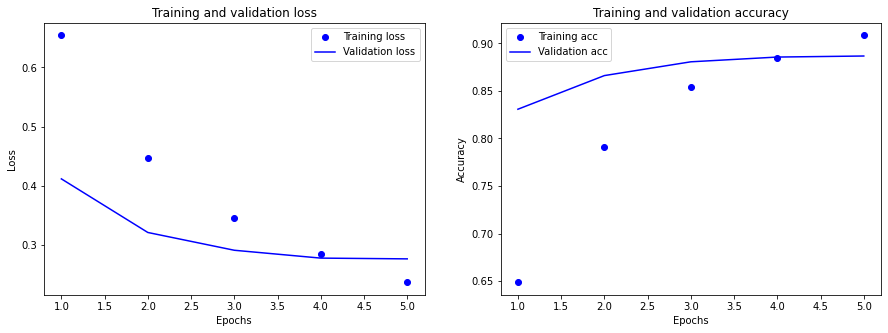

In [34]:
best_hps_2 = tuner.get_best_hyperparameters()[0]
model_hp_2 = tuner.hypermodel.build(best_hps_2)

# Train the model
history_hp_2 = model_hp_2.fit(
    x_train,
    y_train,
    epochs=5,
    validation_data=(x_val, y_val))

history_dict_hp_2 = history_hp_2.history

plot_loss_acc(history_dict_hp_2)

# Validation set (2)

In [35]:
models = [model_1a, model_hp, model_hp_2]
models_names = ['model_1a  ', 'model_hp  ', 'model_hp_2']

for n, m in zip(models_names, models):
    r = m.evaluate(x_val, y_val, verbose=0)
    print(f"{n} loss = {r[0]:.3f} --- accuracy = {r[1]:.3f}")

model_1a   loss = 0.278 --- accuracy = 0.890
model_hp   loss = 0.351 --- accuracy = 0.873
model_hp_2 loss = 0.277 --- accuracy = 0.887


# Test set

In [36]:
# models = [model_1, model_1a, model_2]
# models_names = ['model_1 ', 'model_1a', 'model_2']
for n, m in zip(models_names, models):
    r = m.evaluate(x_test, y_test, batch_size=512, verbose=0)
    print(f"{n} -- Test loss = {r[0]:.3f} --- Test accuracy = {r[1]:.3f}")
    #print("-"*60)

model_1a   -- Test loss = 0.296 --- Test accuracy = 0.880
model_hp   -- Test loss = 0.372 --- Test accuracy = 0.863
model_hp_2 -- Test loss = 0.293 --- Test accuracy = 0.878


Model 1a hat the highest test accuracy